In [1]:
!pip install geopandas shapely fiona pyproj --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.6/56.6 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 45.5 MB/s eta 0:00:00


In [2]:
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import LineString
from google.colab import files

In [3]:
# Upload shapefiles
uploaded = files.upload()

Saving coastal_district_for_Negombo_Galle.cpg to coastal_district_for_Negombo_Galle.cpg
Saving coastal_district_for_Negombo_Galle.dbf to coastal_district_for_Negombo_Galle.dbf
Saving coastal_district_for_Negombo_Galle.prj to coastal_district_for_Negombo_Galle.prj
Saving coastal_district_for_Negombo_Galle.qmd to coastal_district_for_Negombo_Galle.qmd
Saving coastal_district_for_Negombo_Galle.shp to coastal_district_for_Negombo_Galle.shp
Saving coastal_district_for_Negombo_Galle.shx to coastal_district_for_Negombo_Galle.shx
Saving Western_SriLanka_Shoreline_2020_Cleaned.cpg to Western_SriLanka_Shoreline_2020_Cleaned.cpg
Saving Western_SriLanka_Shoreline_2020_Cleaned.dbf to Western_SriLanka_Shoreline_2020_Cleaned.dbf
Saving Western_SriLanka_Shoreline_2020_Cleaned.fix to Western_SriLanka_Shoreline_2020_Cleaned.fix
Saving Western_SriLanka_Shoreline_2020_Cleaned.prj to Western_SriLanka_Shoreline_2020_Cleaned.prj
Saving Western_SriLanka_Shoreline_2020_Cleaned.shp to Western_SriLanka_Shoreline

In [4]:
shoreline_2020 = gpd.read_file("Western_SriLanka_Shoreline_2020_Cleaned.shp")
shoreline_2024 = gpd.read_file("Western_SriLanka_Shoreline_2024_Cleaned.shp")
coastal_boundary = gpd.read_file("coastal_district_for_Negombo_Galle.shp")

In [5]:
# Set CRS (EPSG:5235)
shoreline_2020 = shoreline_2020.to_crs("EPSG:5235")
shoreline_2024 = shoreline_2024.to_crs("EPSG:5235")
coastal_boundary = coastal_boundary.to_crs("EPSG:5235")

/tmp/ipython-input-6-1980461470.py:2: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  coastal_union = coastal_boundary.unary_union
/usr/local/lib/python3.11/dist-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/tmp/ipython-input-6-1980461470.py:50: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend(title="Erosion Risk Level")
/tmp/ipython-input-6-1980461470.py:50: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an undersc

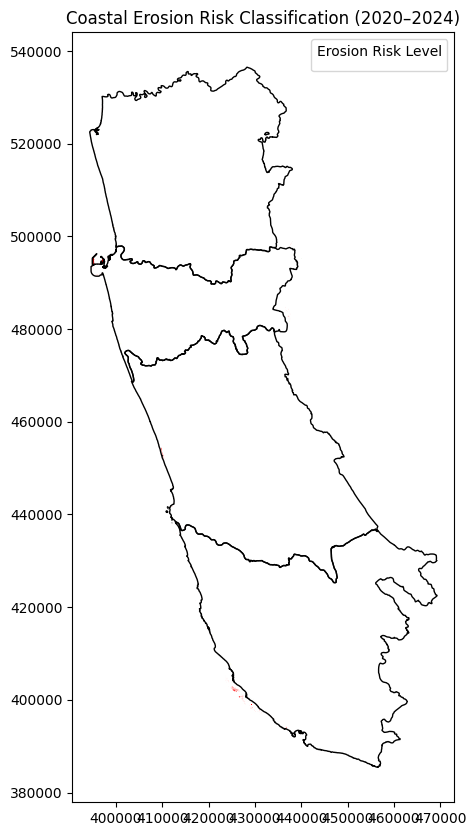

In [6]:
# Dissolve coastal boundary to create a single polygon
coastal_union = coastal_boundary.unary_union

# Approximate sea-facing edge by outward buffer
seaward_buffer = gpd.GeoSeries(coastal_union).buffer(500)
sea_edge = seaward_buffer.boundary.difference(coastal_union.boundary)

# Create a coastal strip (~1 km buffer inland)
coastal_strip = sea_edge.buffer(1000)
coastal_strip_gdf = gpd.GeoDataFrame(geometry=coastal_strip, crs="EPSG:5235")

# Keep only shoreline polygons that intersect with coastal strip
shoreline_2020_coast = gpd.overlay(shoreline_2020, coastal_strip_gdf, how='intersection')
shoreline_2024_coast = gpd.overlay(shoreline_2024, coastal_strip_gdf, how='intersection')

# Calculate erosion = areas in 2020 not in 2024
erosion = gpd.overlay(shoreline_2020_coast, shoreline_2024_coast, how='difference')

# Remove small polygons
erosion['area'] = erosion.geometry.area
erosion_filtered = erosion[erosion['area'] > 1000]

# Classify erosion risk based on area (in square meters)
def classify_risk(area):
    if area < 2000:
        return "Low"
    elif area < 5000:
        return "Moderate"
    elif area < 10000:
        return "High"
    else:
        return "Very High"

erosion_filtered['Risk_Level'] = erosion_filtered['area'].apply(classify_risk)

# Plot with color-coded risk levels
risk_colors = {
    "Low": "green",
    "Moderate": "yellow",
    "High": "orange",
    "Very High": "red"
}

fig, ax = plt.subplots(figsize=(12, 10))
coastal_boundary.boundary.plot(ax=ax, color='black', linewidth=1)

for risk, color in risk_colors.items():
    erosion_filtered[erosion_filtered['Risk_Level'] == risk].plot(ax=ax, color=color, label=risk)

plt.legend(title="Erosion Risk Level")
plt.title("Coastal Erosion Risk Classification (2020–2024)")
plt.show()

# Save the result with risk labels
output_filename = "Erosion_With_RiskLevels.shp"
erosion_filtered.to_file(output_filename)



In [7]:
# Offer shapefile for download
for ext in ['shp', 'shx', 'dbf', 'prj', 'cpg']:
    try:
        files.download(f"Erosion_With_RiskLevels.{ext}")
    except:
        pass


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>